In [1]:
import os, sys
import base64
import matplotlib.pyplot as plt
import io
import pandas as pd
from PIL import Image

target_cwd = '/workspace/repo/cccrawl'
sys.path.append(target_cwd)
sys.path.append('/workspace/repo/cccrawl/OmniParser')
os.chdir(target_cwd)
print(os.getcwd())

from bing_search.models import OmniParserModel

/workspace/repo/cccrawl


In [2]:
model = OmniParserModel()

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


OmniParser/imgs/windows_multitab.png
image size: (3237, 2157)

image 1/1 /workspace/repo/cccrawl/OmniParser/imgs/windows_multitab.png: 864x1280 100 icons, 14.6ms
Speed: 6.5ms preprocess, 14.6ms inference, 2.0ms postprocess per image at shape (1, 3, 864, 1280)
161


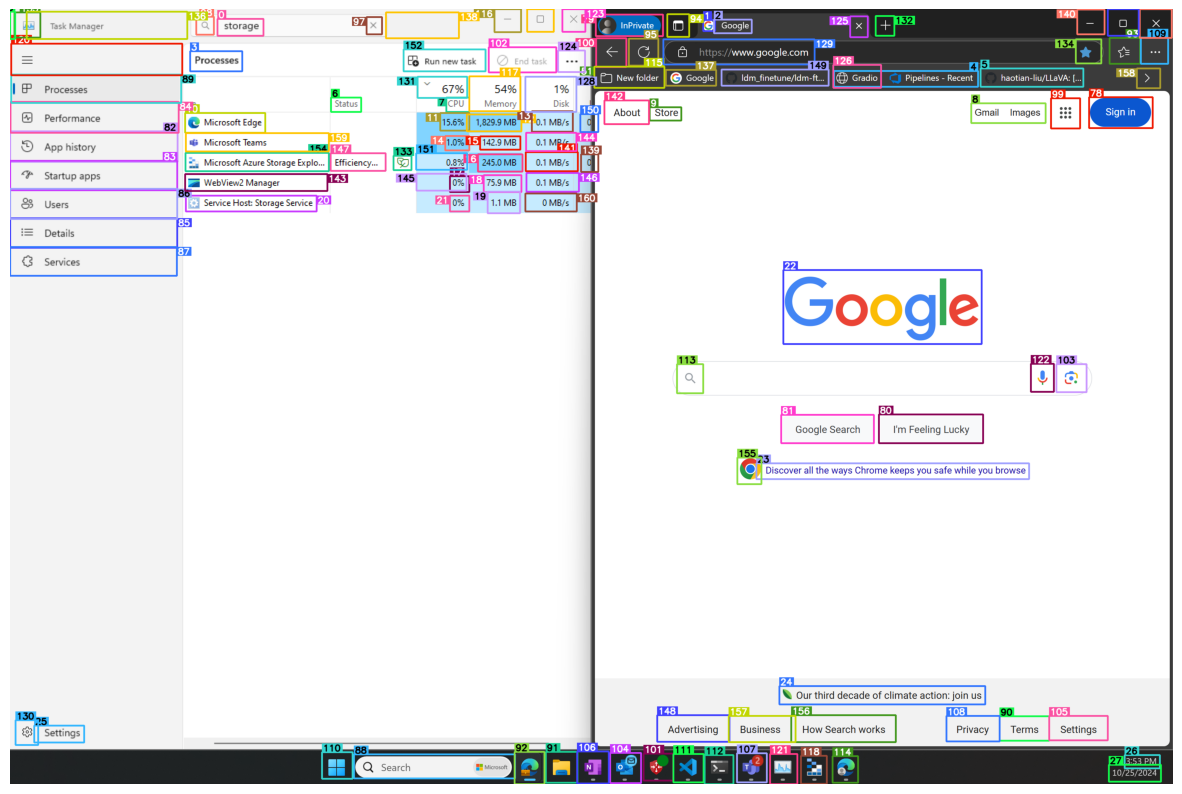

In [5]:

plt.figure(figsize=(15,15))

image_root_path ='OmniParser/imgs'

meta_data = []

for image_path in os.listdir(image_root_path):
	image_path = os.path.join(image_root_path, image_path)
	print(image_path)
	results = model.process_image(image_path)
	
	dino_labled_img = results['dino_labled_img']
	label_coordinates = results['label_coordinates']
	parsed_content_list = results['parsed_content_list']
	w, h = results['image_size']
	
	# save dino_labled_img to file

	image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
	
	image.save('output.png')

	plt.axis('off')
	plt.imshow(image)

	print(len(parsed_content_list))

	def convert(parsed_content_list):
		results = []
		for item in parsed_content_list:
			result = {
				'img_filename': image_path,
				'bbox': [
					int(item['bbox'][0] * w),
					int(item['bbox'][1] * h),
					int(item['bbox'][2] * w),
					int(item['bbox'][3] * h)
				],
				'instruction': item['content'],
				'data_app': "data_app",
				'data_source': item['type'],
				'resolution': (w,h)
			}
			results.append(result)
		return results

	results = convert(parsed_content_list)

	meta_data.extend(results)

	break
	

# label_coordinates is a list of dictionaries with the following format:
# {
# 'type': 'text',
# 'bbox': [0.17,0.01,0.21,0.03], # [v[0]/w, v[1]/h, v[2]/w, v[3]/h]
# 'interactivity': False,
# 'content': 'storage'
# },

# i need to convert the bbox to the format that is used in the dataset
# {
#     "img_filename": "pc_pl3ry1.png",
#     "bbox": [
#       x1,
#       y2,
#       x2,
#       y2
#     ],
#     "instruction": "update all available apps",
#     "data_app": "Paint", 
#     "data_source": "xxx", 
#     "resolution": 
#   },

In [ ]:
import json

from bing_search.util import generativedatasets_get_dir, generativedatasets_path_to_info

org_data_root = "/mnt/vground/generativedatasets/generativedatasets/gold_en/collection=base/data/office/"

dirs, meta = generativedatasets_get_dir(org_data_root)

save_data_root = '/mnt/vground/generativedatasets/generativedatasets_processed/gold_en/collection=base/data/office/'

meta_data = []

for dir in dirs:
	image_paths = [os.path.join(dir, file_name) for file_name in os.listdir(dir) if file_name.endswith('.png')]
	dir_info = generativedatasets_path_to_info(dir)
	app = dir_info['app']

	for image_path in image_paths:
		print(image_path)
		results = model.process_image(image_path)
		dino_labled_img = results['dino_labled_img']
		parsed_content_list = results['parsed_content_list']
		w, h = results['image_size']
		# save dino_labled_img to file
		image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))

		image_save_path = image_path.replace(org_data_root, save_data_root).replace('.png', '_parsed.png')

		save_dir = os.path.dirname(image_save_path)

		os.makedirs(save_dir, exist_ok=True)

		image.save(image_save_path)
	
		print(len(parsed_content_list))

		def convert(parsed_content_list,image_path, app, w, h):
			results = []
			for item in parsed_content_list:
				result = {
					'img_filename': image_path.replace(org_data_root, ''),
					'bbox': [
						int(item['bbox'][0] * w),
						int(item['bbox'][1] * h),
						int(item['bbox'][2] * w),
						int(item['bbox'][3] * h)
					],
					'instruction': item['content'],
					'data_app': app,
					'data_source': item['type'],
					'resolution': (w,h)
				}
				results.append(result)
			return results
		
		results = convert(parsed_content_list, image_path, app, w, h)

		# save results to json
		json_save_path = image_save_path.replace('.png', '_parsed.json')
		with open(json_save_path, 'w') as f:
			json.dump(results, f)

		print(f'save image to {image_save_path}, json to {json_save_path}')

		meta_data.extend(results)
		break

df = pd.DataFrame(meta_data)
df.to_csv(os.path.join(save_data_root, 'metadata.csv'), index=False)


In [ ]:
meta_file  = '/workspace/repo/cccrawl/generativedatasets_processed/metadata.csv'

df = pd.read_csv(meta_file)

df.head()